# RAFT-Stereo

```
@inproceedings{lipson2021raft,
  title={RAFT-Stereo: Multilevel Recurrent Field Transforms for Stereo Matching},
  author={Lipson, Lahav and Teed, Zachary and Deng, Jia},
  booktitle={International Conference on 3D Vision (3DV)},
  year={2021}
}
```

Github Repo: https://github.com/princeton-vl/RAFT-Stereo

Paper: https://arxiv.org/pdf/2109.07547.pdf

# FUNÇÕES NECESSÁRIAS

In [1]:
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from pathlib import Path
from tqdm import tqdm
from PIL import Image
import numpy as np
import cv2 as cv
import argparse
import torch
import glob
import sys
import os

In [2]:
#This function creates a figure to show subplots automatically
def show_subplot(images, titles, gridFormat, figSize=(6, 6), cmap="gray", output_fig_name="output.png", export=False):
    fig = plt.figure(figsize=figSize, dpi=150)
    st = fig.suptitle(output_fig_name, fontsize="large")

    for idx, image in enumerate(images):
        idx_curr_img = int(str(gridFormat[0]) + str(gridFormat[1]) + str(idx+1))
        plt.subplot(idx_curr_img).set_title(titles[idx])
        plt.subplot(idx_curr_img).axis('off')
        plt.imshow(image, cmap=cmap)

    fig.tight_layout()
    st.set_y(0.95)
    fig.subplots_adjust(top=0.85)

    if export:
        plt.savefig(output_fig_name, dpi=300)

    plt.show()

In [3]:
"""Normaliza entradas entre 0 e 1, depois converte entre 0 e 255"""
def normalize_values(img):
    imax = np.max(img)
    imin = np.min(img)
    img_norm = (img-imin)/(imax-imin)
    img_norm = (img_norm * 255).astype(np.int32)
    return img_norm

"""Normaliza entradas entre 0 e 1"""
def normalize_values_0_1(img):
    imax = np.max(img)
    imin = np.min(img)
    img_norm = (img-imin)/(imax-imin)
    img_norm = (img_norm).astype(np.float32)
    return img_norm

"""Calcula o erro"""
def rms_error(img, out):
    img = normalize_values(img)
    out = normalize_values(out)
    M,N = img.shape
    error = ((1/(M*N))*np.sum((img-out)**2))**(1/2)
    return error

In [4]:
#This function load images using IMAGEIO library
def load_image_imageio(path_img, resize=None):
    img = imageio.imread(path_img)

    if resize:
        resCols, resRows = resize
        img = Image.fromarray(img).resize((resCols, resRows))

    return np.array(img)

#This function load and converts '.pfm' files into images
def load_pfm_files(path_file, resize=None, normalize=None):
    #Reference: https://copyprogramming.com/howto/opencv-how-to-read-pfm-files

    #Load input data
    pfm_img = cv.imread(path_file, cv.IMREAD_UNCHANGED)

    # Remove infinite value to display
    pfm_img[pfm_img==np.inf] = 0

    if resize:
        resCols, resRows = resize
        pfm_img = cv.resize(pfm_img,
                           (resCols, resRows),
                            interpolation = cv.INTER_LINEAR) #Image.fromarray(pfm_img).resize((resCols, resRows))

    # Normalize
    if normalize:
        min, max = 0, 255
        pfm_img = cv.normalize(pfm_img, None, min, max, cv.NORM_MINMAX).astype(np.float32)

    return pfm_img

In [5]:
try:
    import wget
except:
    !pip install wget
    import wget

In [6]:
# !git clone --recursive https://github.com/princeton-vl/RAFT-Stereo.git

In [7]:
cd RAFT-Stereo

/Users/sherlonalmeida/Desktop/Estudo/DeepModels/RAFT-Stereo


/Users/sherlonalmeida/Desktop/Estudo/.venv/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [8]:
# Download model weights and sample data
# Criar a pasta RAFT-Stereo/models e adicionar o arquivo zip lá dentro, depois descompactar.
# Link para download: https://www.dropbox.com/s/ftveifyqcomiwaq/models.zip

## Obtaining Input Data

In [9]:
size = 256
size_w,size_h = size,size

path_imgL = f"imL_{size}.png"
path_imgR = f"imR_{size}.png"

path_gt_L = "disp0.pfm"
path_gt_R = "disp1.pfm"

In [10]:
# Baixar o Dataset desejado e adicionar na pasta Sherlon/

# #DATASET: https://vision.middlebury.edu/stereo/data/scenes2014/datasets/
# url = 'https://vision.middlebury.edu/stereo/data/scenes2014/datasets/Flowers-perfect/'
# if not os.path.isfile(path_imgL):
#     wget.download(url+path_imgL)
# if not os.path.isfile(path_imgR):
#     wget.download(url+path_imgR)
# if not os.path.isfile(path_gt_L):
#     wget.download(url+path_gt_L)
# if not os.path.isfile(path_gt_R):
#     wget.download(url+path_gt_R)
# if not os.path.isfile("calib.txt"):
#     wget.download(url+"calib.txt")

In [11]:
%cd Sherlon

/Users/sherlonalmeida/Desktop/Estudo/DeepModels/RAFT-Stereo/Sherlon


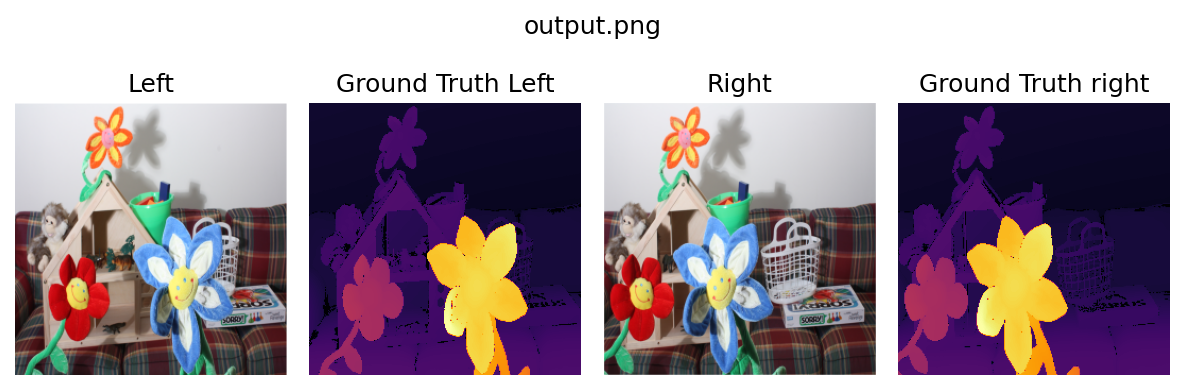

In [12]:
#Load Images
imgL = load_image_imageio(path_imgL, resize=None)
imgR = load_image_imageio(path_imgR, resize=None)

#Load Ground Truth
gt_L = load_pfm_files(path_gt_L, resize=(size_w,size_h))
gt_R = load_pfm_files(path_gt_R, resize=(size_w,size_h))

#Show images side-by-side
show_subplot(images=[imgL, gt_L, imgR, gt_R],
             titles=["Left", "Ground Truth Left", "Right", "Ground Truth right"],
             gridFormat=(1, 4),
             figSize=(8, 3),
             cmap="inferno")

In [13]:
# #Move files to new folder Sherlon
# !mkdir Sherlon
# !mv im0.png Sherlon/
# !mv im1.png Sherlon/
# !mv disp0.pfm Sherlon/
# !mv disp1.pfm Sherlon/
# !mv calib.txt Sherlon/

## Obtaining Correlation Matrix

In [14]:
%cd ..

/Users/sherlonalmeida/Desktop/Estudo/DeepModels/RAFT-Stereo


In [15]:
sys.path.append('core')
from raft_stereo import RAFTStereo
from utils.utils import InputPadder
DEVICE = 'cpu'

In [16]:
%cd core

/Users/sherlonalmeida/Desktop/Estudo/DeepModels/RAFT-Stereo/core


/Users/sherlonalmeida/Desktop/Estudo/.venv/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [17]:
def load_image(imfile):
    img = np.array(Image.open(imfile)).astype(np.uint8)
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    return img[None].to(DEVICE)

def demo(args):
    model = torch.nn.DataParallel(RAFTStereo(args), device_ids=[0])
    model.load_state_dict(torch.load(args.restore_ckpt, map_location=torch.device('cpu')))

    model = model.module
    model.to(DEVICE)
    model.eval()

    output_directory = Path(args.output_directory)
    output_directory.mkdir(exist_ok=True)

    with torch.no_grad():
        left_images = sorted(glob.glob(args.left_imgs, recursive=True))
        right_images = sorted(glob.glob(args.right_imgs, recursive=True))
        print(f"Found {len(left_images)} images. Saving files to {output_directory}/")

        for (imfile1, imfile2) in tqdm(list(zip(left_images, right_images))):
            image1 = load_image(imfile1)
            image2 = load_image(imfile2)
            padder = InputPadder(image1.shape, divis_by=32)
            image1, image2 = padder.pad(image1, image2)

            diff, flow_up, data_correlation, coords, corr_fn, up_mask = model(image1, image2, iters=args.valid_iters, test_mode=True)
            flow_up = padder.unpad(flow_up).squeeze()

            file_stem = imfile1.split('/')[-2]
            if args.save_numpy:
                np.save(output_directory / f"{file_stem}.npy", flow_up.cpu().numpy().squeeze())
            plt.imsave(output_directory / f"{file_stem}.png", -flow_up.cpu().numpy().squeeze(), cmap='jet')
    
    return diff, flow_up, data_correlation, coords, corr_fn, up_mask

# if __name__ == '__main__':
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--restore_ckpt', help="restore checkpoint", required=True)
#     parser.add_argument('--save_numpy', action='store_true', help='save output as numpy arrays')
#     parser.add_argument('-l', '--left_imgs', help="path to all first (left) frames", default="datasets/Middlebury/MiddEval3/testH/*/im0.png")
#     parser.add_argument('-r', '--right_imgs', help="path to all second (right) frames", default="datasets/Middlebury/MiddEval3/testH/*/im1.png")
#     parser.add_argument('--output_directory', help="directory to save output", default="demo_output")
#     parser.add_argument('--mixed_precision', action='store_true', help='use mixed precision')
#     parser.add_argument('--valid_iters', type=int, default=32, help='number of flow-field updates during forward pass')

#     # Architecture choices
#     parser.add_argument('--hidden_dims', nargs='+', type=int, default=[128]*3, help="hidden state and context dimensions")
#     parser.add_argument('--corr_implementation', choices=["reg", "alt", "reg_cuda", "alt_cuda"], default="reg", help="correlation volume implementation")
#     parser.add_argument('--shared_backbone', action='store_true', help="use a single backbone for the context and feature encoders")
#     parser.add_argument('--corr_levels', type=int, default=4, help="number of levels in the correlation pyramid")
#     parser.add_argument('--corr_radius', type=int, default=4, help="width of the correlation pyramid")
#     parser.add_argument('--n_downsample', type=int, default=2, help="resolution of the disparity field (1/2^K)")
#     parser.add_argument('--context_norm', type=str, default="batch", choices=['group', 'batch', 'instance', 'none'], help="normalization of context encoder")
#     parser.add_argument('--slow_fast_gru', action='store_true', help="iterate the low-res GRUs more frequently")
#     parser.add_argument('--n_gru_layers', type=int, default=3, help="number of hidden GRU levels")

#     args = parser.parse_args()

#     demo(args)

# !source activate raftstereo && python demo.py --restore_ckpt models/raftstereo-middlebury.pth \
# --corr_implementation alt --mixed_precision \
# -l=datasets/Middlebury/MiddEval3/testF/Sherlon/im0.png \
# -r=datasets/Middlebury/MiddEval3/testF/Sherlon/im1.png \
# --save_numpy

# Convert dictionary to Namespace
args = argparse.Namespace(
    left_imgs='../Sherlon/'+path_imgL,
    right_imgs='../Sherlon/'+path_imgR,
    restore_ckpt='../models/raftstereo-eth3d.pth',
    corr_implementation='alt',
    output_directory='../demo_output',
    context_norm='batch',
    corr_levels=4, corr_radius=4,
    hidden_dims=[128, 128, 128],
    n_downsample=2,
    n_gru_layers=3,
    valid_iters=2, #No exemplo eles usam 32 (Quanto mais, melhor o resultado, porém mais lento fica)
    mixed_precision=True,
    save_numpy=True,
    shared_backbone=False,
    slow_fast_gru=False,
)

diff, flow_up, data_correlation, coords, corr_fn, up_mask = demo(args)

Entrou aqui 1 -> class RAFTStereo __init__() ...
Found 1 images. Saving files to ../demo_output/


  0%|          | 0/1 [00:00<?, ?it/s]/Users/sherlonalmeida/Desktop/Estudo/.venv/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Entrou aqui 2 -> class RAFTStereo forward() ...
inp_List -> 3
0 0 torch.Size([1, 128, 64, 64])
0 1 torch.Size([1, 128, 64, 64])
0 2 torch.Size([1, 128, 64, 64])
1 0 torch.Size([1, 128, 32, 32])
1 1 torch.Size([1, 128, 32, 32])
1 2 torch.Size([1, 128, 32, 32])
2 0 torch.Size([1, 128, 16, 16])
2 1 torch.Size([1, 128, 16, 16])
2 2 torch.Size([1, 128, 16, 16])

Iteration 0 ...
Out: torch.Size([1, 64, 64, 36])
Executando GRU... True True True True


/Users/sherlonalmeida/Desktop/Estudo/.venv/lib/python3.9/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Iteration 1 ...
Out: torch.Size([1, 64, 64, 36])
Executando GRU... True True True True
up_mask torch.Size([1, 144, 64, 64])
Entrou aqui 2 -> retornando informacoes obtidas ...


In [18]:
256/16

16.0

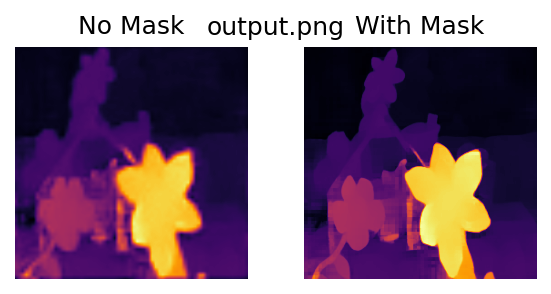

Flow No Mask torch.Size([256, 256])
Flow With Mask torch.Size([256, 256])


In [19]:
#Obtendo o resultado com UPSAMPLING
import torch.nn.functional as F

# Sherlon: ADAPTEI essa funcao do codigo original (antes era upflow_8 e eu generalizei para N)
def upflow_N(flow, mode='bilinear', factor=8):
    new_size = (factor * flow.shape[2], factor * flow.shape[3])
    return  factor * F.interpolate(flow, size=new_size, mode=mode, align_corners=True)

# Sherlon: Copiei essa funcao do codigo original
def upsample_flow(flow, mask):
        """ Upsample flow field [H/8, W/8, 2] -> [H, W, 2] using convex combination """
        N, D, H, W = flow.shape
        factor = 2 ** args.n_downsample
        mask = mask.view(N, 1, 9, factor, factor, H, W)
        mask = torch.softmax(mask, dim=2)

        up_flow = F.unfold(factor * flow, [3,3], padding=1)
        up_flow = up_flow.view(N, D, 9, 1, 1, H, W)

        up_flow = torch.sum(mask * up_flow, dim=2)
        up_flow = up_flow.permute(0, 1, 4, 2, 5, 3)
        return up_flow.reshape(N, D, factor*H, factor*W)

flow_up_no_mask = upflow_N(coords[1] - coords[0], factor=4)[:,:1].squeeze()
flow_up_mask = upsample_flow(coords[1] - coords[0], up_mask)[:,:1].squeeze()

#Show images side-by-side
show_subplot(images=[-flow_up_no_mask, -flow_up_mask],
             titles=["No Mask", "With Mask"],
             gridFormat=(1, 2),
             figSize=(4, 2),
             cmap="inferno")
print("Flow No Mask", flow_up_no_mask.shape)
print("Flow With Mask", flow_up_mask.shape)

In [20]:
up_mask.shape

torch.Size([1, 144, 64, 64])

In [21]:
teste = diff.squeeze()
teste = teste.permute(1,2,0)
my_corr = teste[:,:,0] #Mantendo apenas os valores por linhas (Epipolar)

import pandas as pd
df = pd.DataFrame(my_corr)

In [22]:
df.describe()

0          1          2          3          4          5   \
count  64.000000  64.000000  64.000000  64.000000  64.000000  64.000000   
mean   -1.736001  -1.595445  -1.680571  -1.845172  -1.784889  -1.725682   
std     1.306832   1.198840   1.330694   1.724548   1.673225   1.460621   
min    -4.839243  -4.588319  -7.062948 -10.268259  -7.919388  -6.590367   
25%    -2.594646  -2.042488  -2.298695  -2.648558  -2.561636  -2.552514   
50%    -1.538087  -1.229794  -1.371837  -1.468748  -1.357257  -1.274718   
75%    -0.503575  -0.595586  -0.553424  -0.605596  -0.553790  -0.518143   
max    -0.412368  -0.434183  -0.378926  -0.288174   0.003828   0.182283   

              6          7          8          9   ...         54         55  \
count  64.000000  64.000000  64.000000  64.000000  ...  64.000000  64.000000   
mean   -2.245708  -2.839254  -2.827272  -2.980143  ...  -1.477924  -1.471781   
std     1.552410   2.086338   2.033318   2.096582  ...   0.720240   0.735176   
min    -5.738988  -6.786118  -6.447309  -6.533513  ...  -2.914139  -2.882557   
25%    -3.357660  -4.588415  -4.459550  -5.017900  ...  -1.949710  -1.956562   
50%    -2.497066  -2.620363  -2.672854  -2.717813  ...  -1.375238  -1.378714   
75%    -0.580092  -0.648199  -0.583367  -0.665407  ...  -0.829290  -0.776681   
max    -0.176609  -0.459124  -0.465997  -0.504855  ...  -0.523903  -0.480865   

              56         57         58         59         60         61  \
count  64.000000  64.000000  64.000000  64.000000  64.000000  64.000000   
mean   -1.459078  -1.472371  -1.486329  -1.480148  -1.492617  -1.482073   
std     0.762673   0.771952   0.774117   0.785036   0.770681   0.740425   
min    -2.924324  -2.943546  -2.960938  -2.963375  -3.001827  -2.882782   
25%    -1.936829  -1.948568  -2.007989  -2.093616  -2.084793  -2.075832   
50%    -1.375433  -1.379492  -1.398684  -1.388275  -1.421833  -1.423262   
75%    -0.740683  -0.747122  -0.775372  -0.749468  -0.786286  -0.859135   
max    -0.555187  -0.549774  -0.567688  -0.505619  -0.459877  -0.458054   

              62         63  
count  64.000000  64.000000  
mean   -1.481296  -1.403731  
std     0.767346   0.778414  
min    -2.920807  -3.074734  
25%    -1.983832  -1.911908  
50%    -1.360886  -1.464956  
75%    -0.893291  -0.680903  
max    -0.432564  -0.293472  

[8 rows x 64 columns]

<Axes: >

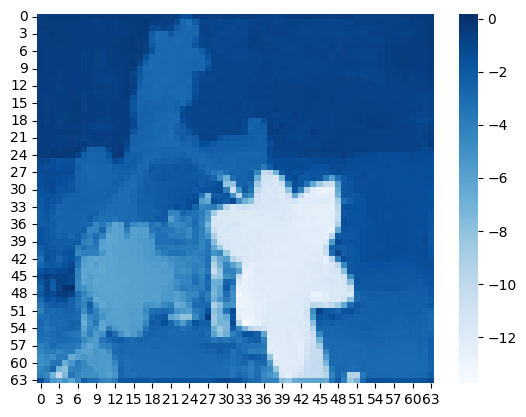

In [23]:
import seaborn as sns
from scipy.special import softmax

sns.heatmap(df, annot=False, cmap="Blues") #Show

In [24]:
coords0 = coords[0].squeeze().permute(1,2,0)
coords1 = coords[1].squeeze().permute(1,2,0)
#coords1 - coords0
print(coords1)

tensor([[[-0.5630,  0.0000],
         [ 0.4996,  0.0000],
         [ 1.6211,  0.0000],
         ...,
         [60.5419,  0.0000],
         [61.5674,  0.0000],
         [62.6614,  0.0000]],

        [[-0.5578,  1.0000],
         [ 0.5658,  1.0000],
         [ 1.5097,  1.0000],
         ...,
         [60.4129,  1.0000],
         [61.5106,  1.0000],
         [62.6714,  1.0000]],

        [[-0.4124,  2.0000],
         [ 0.5121,  2.0000],
         [ 1.5024,  2.0000],
         ...,
         [60.3811,  2.0000],
         [61.4842,  2.0000],
         [62.6299,  2.0000]],

        ...,

        [[-4.3004, 61.0000],
         [-2.9325, 61.0000],
         [-0.7104, 61.0000],
         ...,
         [58.1172, 61.0000],
         [59.0849, 61.0000],
         [60.4924, 61.0000]],

        [[-4.0280, 62.0000],
         [-3.5883, 62.0000],
         [-5.0629, 62.0000],
         ...,
         [58.1431, 62.0000],
         [59.2223, 62.0000],
         [60.8451, 62.0000]],

        [[-1.2469, 63.0000],
       

In [25]:
#Para cada iter tem 4 níveis de Pyramid (Por isso 2 * 4 = 8)
print(len(corr_fn.corr_pyramid))
for i in range(len(corr_fn.corr_pyramid)):
    print(i, corr_fn.corr_pyramid[i].shape)

0


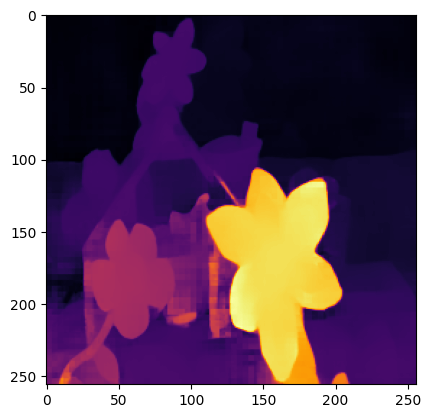

In [26]:
plt.imshow(-flow_up, cmap="inferno")
plt.show()

## **Results:** Obtaining Error

In [27]:
testF_folder = Path("../Sherlon")

disp_path = f"../demo_output/{testF_folder.name}.npy"
disp = np.load(disp_path)
image = imageio.imread(testF_folder / path_imgL)

In [28]:
#Normalizing result
result = 255 - normalize_values(disp)
gt_L_norm = normalize_values(gt_L)

In [29]:
#Disparidade real
np.min(disp), np.max(disp)

(np.float32(-52.60658), np.float32(-1.0317385))

In [30]:
#Calculating Error between Result and Ground Truth
error = rms_error(result, gt_L_norm)
print(error)

18.439782780424984


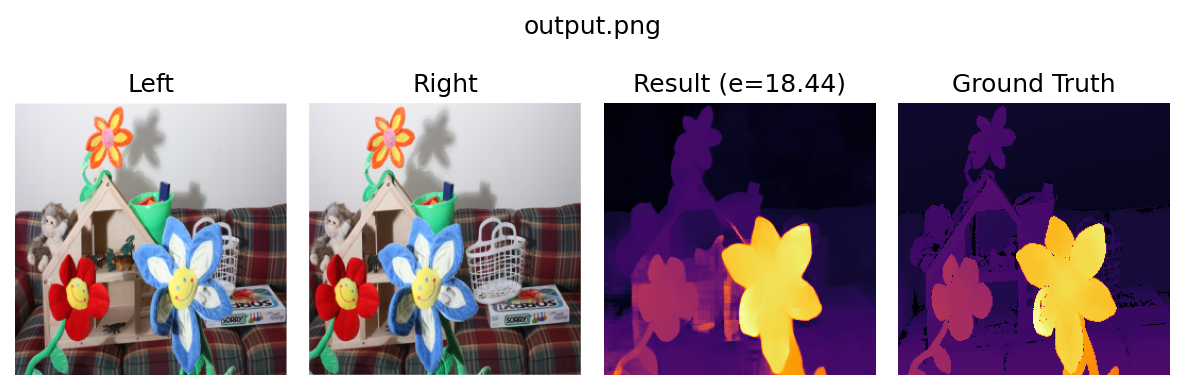

In [31]:
#Show images side-by-side
show_subplot(images=[imgL, imgR, result, gt_L_norm],
             titles=["Left", "Right", f"Result (e={error:.2f})", "Ground Truth"],
             gridFormat=(1, 4),
             figSize=(8, 3),
             cmap="inferno")

## Visualizing 3D Points

In [32]:
# Calibration
fx, fy, cx1, cy = 3997.684, 3997.684, 1176.728, 1011.728
cx2 = 1307.839
baseline=193.001 # in millimeters

In [33]:
testF_folder = Path("../Sherlon")

disp_path = f"../demo_output/{testF_folder.name}.npy"
disp = np.load(disp_path)
image = imageio.imread(testF_folder / path_imgL)

# inverse-project
depth = (fx * baseline) / (-disp + (cx2 - cx1))
H, W = depth.shape
xx, yy = np.meshgrid(np.arange(W), np.arange(H))
points_grid = np.stack(((xx-cx1)/fx, (yy-cy)/fy, np.ones_like(xx)), axis=0) * depth

mask = np.ones((H, W), dtype=bool)

# Remove flying points
mask[1:][np.abs(depth[1:] - depth[:-1]) > 1] = False
mask[:,1:][np.abs(depth[:,1:] - depth[:,:-1]) > 1] = False

points = points_grid.transpose(1,2,0)[mask]
colors = image[mask].astype(np.float64) / 255

In [34]:
import plotly.graph_objects as go

NUM_POINTS_TO_DRAW = points.shape[0]

subset = np.random.choice(points.shape[0], size=(NUM_POINTS_TO_DRAW,), replace=False)
points_subset = points[subset]
colors_subset = colors[subset]

print("""
Controls:
---------
Zoom:      Scroll Wheel
Translate: Right-Click + Drag
Rotate:    Left-Click + Drag
""")

x, y, z = points_subset.T

fig = go.Figure(
    data=[
        go.Scatter3d(
            x=x, y=-z, z=-y, # flipped to make visualization nicer
            mode='markers',
            marker=dict(size=1, color=colors_subset)
        )
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=True),
            yaxis=dict(visible=True),
            zaxis=dict(visible=True),
        )
    )
)
fig.show()


Controls:
---------
Zoom:      Scroll Wheel
Translate: Right-Click + Drag
Rotate:    Left-Click + Drag

